In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
S_mopsin  = np.loadtxt("mouse_cone_opsins.txt", usecols=(1,))[40::]
S_sopsin  = np.loadtxt("mouse_cone_opsins.txt", usecols=(0,))[40::]
# Ac: o.2 [um^2] --> 0.2*10^-10 [cm^2]
# Ar: o.5 [um^2]
Ac = 0.2*10**-10
Ar = 0.5*10**-10

In [11]:
fl = 'spectrometer/white/20220913_SOLIS1D_750mA_white_FLMS192441__0__14-30-16-630.txt'
#fl = 'spectrometer/UV/solis365c_3750mA_white_FLMS192441__0__16-09-53-763.txt'
# I [mW]
I = 2*10**-3
#I = 0.8 *10**-3

In [24]:
#get normalized spectrometer data
#fl: file location
#hearder lines for removing information of header to extract spectrodata only
def gnsd(fl,hl):
    
    spectroarray = np.loadtxt(fl,skiprows=hl)

    # this code considers wavelength from 340 to700
    lamda_min = 340
    lamda_max = 700
    # cut the data region under 340 nm and over 700
    
    for i in range(len(spectroarray)):
        if spectroarray[0,0] < lamda_min:
            spectroarray = np.delete(spectroarray,0,0)
        else:
            break
    
    for i in range(len(spectroarray)):
        if spectroarray[-1,0] >= lamda_max:
            spectroarray = np.delete(spectroarray,-1,0)
        else:
            break
    # convert to histgram data 
    step = 0
    hist_spect = np.zeros(360)
    
    for k in range(360):
        lamda = lamda_min + k

        while lamda <= spectroarray[step,0] < lamda + 1:

            if spectroarray[step,1] >= 0:
                hist_spect[k] += spectroarray[step,1]
                step+=1
            else:
                step+=1    
                
            if step > len(spectroarray)-1:
                break
    n_bin = 10
    norm_hist_spect = np.convolve(hist_spect,np.ones(n_bin)/float(n_bin),mode='same')
    norm_hist_spect = norm_hist_spect/sum(norm_hist_spect)
    
    return spectroarray, hist_spect, norm_hist_spect
    

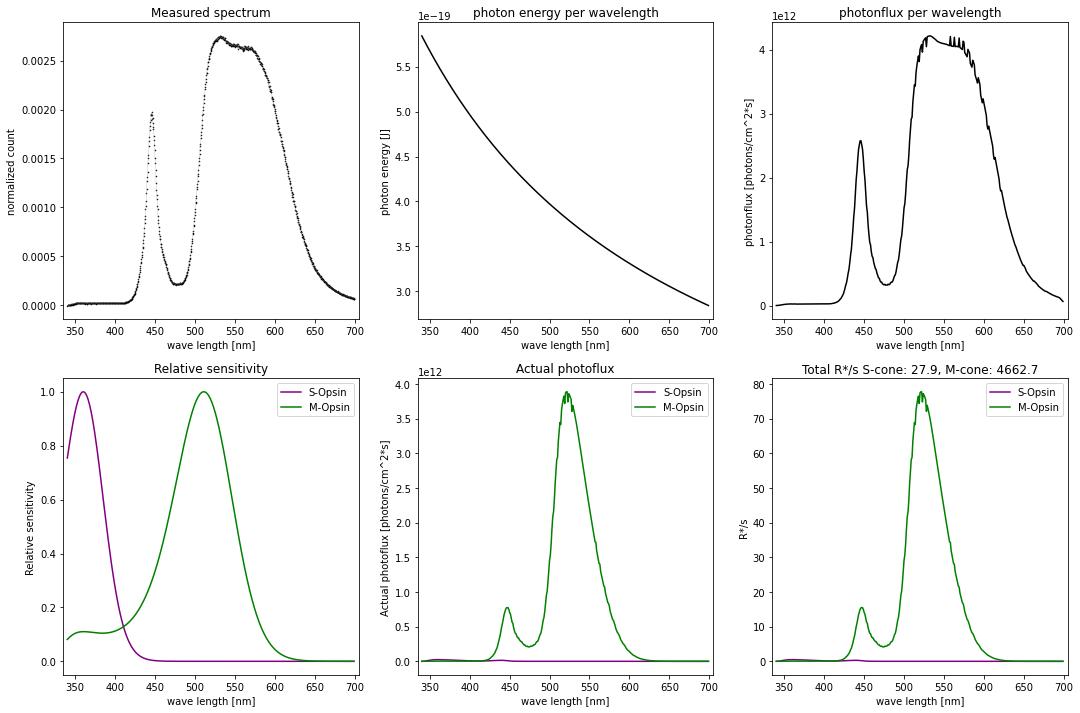

In [26]:
plt.figure(figsize=(18,12),facecolor="w")

# show spectrum

spectro,hist_spect,norm_histgram = gnsd(fl,14)
norm_spectro = spectro[:,1] / sum(spectro[:,1])

plt.subplot(2, 3, 1)
plt.xlim([335,705])
plt.ylabel("normalized count")
plt.xlabel("wave length [nm]")
plt.title("Measured spectrum")
plt.plot(spectro[:,0],norm_spectro,color='gray',linewidth=0.2)
plt.scatter(spectro[:,0],norm_spectro,color='k',s=0.3)

# show the E-lamda curve

# E: Energy l=lamda: wavelength c: speed of light(2.998e8 m/s) h:plank's constant (6.626e-34 [J*s])
# E = hc/l
lamdaarray = np.arange(340,700)
Earray = np.ones(360)*2.998*10**8*6.626*10**-34/(lamdaarray*10**-9)

plt.subplot(2, 3, 2)
plt.xlim([335,705])
plt.ylabel("photon energy [J]")
plt.xlabel("wave length [nm]")
plt.title("photon energy per wavelength")
plt.plot(lamdaarray,Earray, color='k')

# show estimated photon flux

# to get how many photons retina will receive, here we start from estimation of photon flux.
# Earray * norm_histgram means expected value of one photon emmited from the projector we use. Thus unit is [J/photons]
# photon flux is number of photons that retina received [photons/s/cm^2]
# Thus, irradiance (I [mW/mm^2]) we obtained from projector is multiplication of the expected value and photon flux.
# Now we now photon flux (= F) and it can be calculated as L = I*10^2/(integration (Earray * norm_histgram))

F = I*10**-1/(sum(Earray*norm_histgram))

# Then we can estimate photoflux (= F_Slamdba photonflux per wavelength) for each wavelength by multiplication with pf and norm_histgram

F_Slambda = F * norm_histgram

plt.subplot(2, 3, 3)
plt.xlim([335,705])
plt.ylabel("photonflux [photons/cm^2*s]")
plt.xlabel("wave length [nm]")
plt.title("photonflux per wavelength")
plt.plot(lamdaarray, F_Slambda ,color='k')

# Next we may check the characteristic of mice opsins and rhodopsin.
# let relative sensitivity of S-opsin S_sopsin, S-opsin and of M-opsin S_mopsin

plt.subplot(2, 3, 4)
plt.xlim([335,705])
plt.ylabel("Relative sensitivity")
plt.xlabel("wave length [nm]")
plt.title("Relative sensitivity")
plt.plot(lamdaarray, S_sopsin, color='purple', label='S-Opsin')
plt.plot(lamdaarray, S_mopsin, color='g', label='M-Opsin')
plt.legend()

# Next we calculate actual stimulus spectram, S_Act. This can be given by relative sensitivity of opsin and photoflux for each wavelength with the following equations
# S_sAct = S_sopsin * F_Slambda
# S_mAct = S_mopsin * F_Slambda
S_sAct = S_sopsin * F_Slambda
S_mAct = S_mopsin * F_Slambda

plt.subplot(2, 3, 5)
plt.xlim([335,705])
plt.ylabel("Actual photoflux [photons/cm^2*s]")
plt.xlabel("wave length [nm]")
plt.title("Actual photoflux")
plt.plot(lamdaarray, S_sAct, color='purple', label='S-Opsin')
plt.plot(lamdaarray, S_mAct, color='g', label='M-Opsin')
plt.legend()

# Then multiple effective collective area and S_Act, we may get R*/s per each wavelength and integral of it may final answer.
R_sisolambda = S_sAct * Ac
R_misolambda = S_mAct * Ac

R_siso = sum(R_sisolambda)
R_miso = sum(R_misolambda)

plt.subplot(2, 3, 6)
plt.xlim([335,705])
plt.ylabel("R*/s")
plt.xlabel("wave length [nm]")
plt.title("Total R*/s S-cone: %.1f, M-cone: %.1f"%(R_siso,R_miso))
plt.plot(lamdaarray, R_sisolambda, color='purple', label='S-Opsin')
plt.plot(lamdaarray, R_misolambda, color='g', label='M-Opsin')
plt.legend()


# conversion constant, i_conv, from I to R*/s

i_sconv = (Ac*(sum(S_sopsin*norm_histgram)))/(sum(Earray*norm_histgram))
i_mconv = (Ac*(sum(S_mopsin*norm_histgram)))/(sum(Earray*norm_histgram))


plt.savefig("SOLIS1D_300mA_i_mconv=%d.png"%(i_mconv))
